In [8]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
from tqdm import tqdm
import numpy as np
from statsmodels.stats.multitest import fdrcorrection


import warnings
warnings.filterwarnings("ignore")

from scripts.utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, load_from_pickle, get_treatment_info
#sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()

samples = ['MET_A3','MET_GP12','MET_A14','MET_A16']
sample_crop_coord = {
     'MET_A3':(1700,19500,3200,20700),
     'MET_GP12':(-400,17300,2000,19600),
     'MET_A14':(800,18500,2200,19800),
     'MET_A16':(800,18700,700,18300),
        }

In [13]:
# Grab and save sample annotations for all the samples
sample_annot = dict(zip(sample_id_masks.keys(),[s.split(' ')[0] for s in  sample_id_masks.values()]))
annot_df = pd.DataFrame.from_dict(sample_annot,orient='index')
annot_df[1] = annot_df.index.map(get_treatment_info())

annot_df.columns = ['Group','Detailed group']
annot_df.to_csv('./spatial_sample_annotations.csv',index=True)

,Group,Detailed group
BPH_665,BPH,bph
BPH_688,BPH,bph
BPH_651,BPH,bph
BPH_652,BPH,bph
PC_02_10136_VAS,TRNA,untreated
PC_02_05601_OIK,TRNA,untreated
PC_01_14451_OIK,TRNA,untreated
PC_03_01669_TUTKV,TRNA,untreated
PC_06_17800_VAS_POST_0,TRNA,untreated
PC_06_04581_OIK_POST_0,TRNA,untreated


## Data download

In [2]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

region_colors_dict = {
 'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(region_colors_dict.keys())
region_colors = list(region_colors_dict.values())


from scipy.stats import fisher_exact,ttest_ind

def check_cluster_enrichment(dat,gene_signature,return_pvals=False):

    pvals_lst = []
    df_res = sc.get.rank_genes_groups_df(dat,group=None)
    for grp in df_res['group'].cat.categories.tolist():
        genes_lst = df_res[(df_res['group'] == grp) &
                            (df_res['logfoldchanges']>=1) &
                            (df_res['pvals_adj']<0.05)]['names'].tolist()

        total = dat.shape[1]

        deg_overlap = [s for s in gene_signature if s in genes_lst]
        a = len(deg_overlap)
        b = len(gene_signature) - a
        c = len(genes_lst) - a
        d = total - len(genes_lst) - b

        arr = np.array([[a,b],[c,d]])
        stat, pval = fisher_exact(arr,alternative='greater')

        if not return_pvals:        
            if pval < 0.05:
                print('cluster {} enrichment p-value: {:.2e} !!'.format(grp,pval))
                print('Overlap: {}'.format(' '.join(deg_overlap)))
            else:
                print('cluster {} enrichment p-value: {:.3f}'.format(grp,pval))
        
        pvals_lst.append(pval)

    if return_pvals:
        return(pvals_lst)

### Clustering and DE genes

In [ ]:

# Only run once to get and save the clusters
for i,sample in enumerate(samples):

    adata = sc.read_h5ad('./data/normalized_visium/{}_normalized.h5ad'.format(sample))

    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata,resolution=0.5) #

    adata.uns['log1p']["base"] = None
    sc.tl.rank_genes_groups(adata,groupby='leiden',method='wilcoxon')
    #deg_res = sc.get.rank_genes_groups_df(adata,group=None)
    
    adata.write('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))
    del adata

## Scoring and plotting signatures

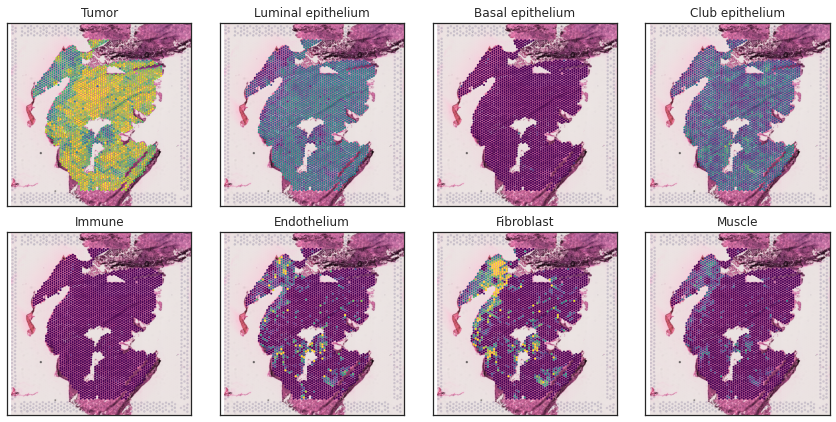

In [13]:
# Score all the regions and plot them onto the same grid

sns.set_theme(style='white')
#for sample in samples:
sample = samples[1]
dat = sc.read_h5ad('./data/normalized_visium/{}_normalized.h5ad'.format(sample))

# Score all the genes & plot the scores on a grid
fig, axes = plt.subplots(2,4,figsize=(12,6))
for i,region in enumerate(regions): 
    genes = check_top_markers(region)['gene'].tolist()
    sc.tl.score_genes(dat,gene_list=genes,score_name=region,use_raw=True)

# Second loop
for i,region in enumerate(regions): 
    ax = axes[i//4, i%4]
    sc.pl.spatial(dat,color=region,title=region,
                            crop_coord=sample_crop_coord[sample],
                            size=1.3, alpha_img=1, legend_loc=None,
                            show=False,ax=ax,
                            vmin=0,
                            vmax=np.quantile(dat.obs[regions].values.flatten(),0.99),
                            colorbar_loc=None,
                            cmap='viridis'
                            )
    ax.set_ylabel('')
    ax.set_xlabel('')

#del dat
plt.tight_layout()
#plt.savefig('./plots/met_samples/{}_region_scores.pdf'.format(sample))
plt.show()

[<AxesSubplot: title={'center': 'Tumor'}, xlabel='spatial1', ylabel='spatial2'>]

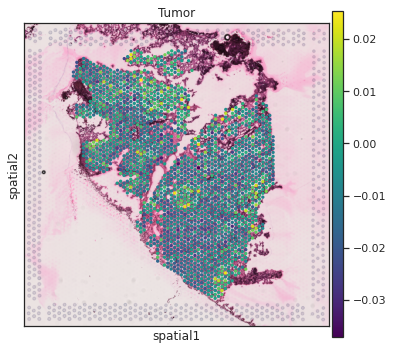

In [12]:
region = ''
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.spatial(dat,color=region,title=region,
                            crop_coord=sample_crop_coord[sample],
                            size=1.3, alpha_img=1, legend_loc=None,
                            show=False,ax=ax,
                            #vmin=0,
                            #vmax=np.quantile(dat.obs[regions].values.flatten(),0.99),
                            #colorbar_loc=None,
                            cmap='viridis'
                            )
    

## Clustering and gene set enrichment

In [372]:

club_markers = check_top_markers('Club epithelium')['gene']
club_senescence = club_markers[club_markers.isin(gene_set_df['MP19 Epithelial Senescence'])].tolist()

club_markers = check_top_markers('Club epithelium')['gene'].tolist()
tumor_markers = check_top_markers('Tumor')['gene'].tolist()
luminal_markers = check_top_markers('Luminal epithelium')['gene'].tolist()
immune_markers = check_top_markers('Immune')['gene'].tolist()

### Plot clusters on spatial for an individual sample

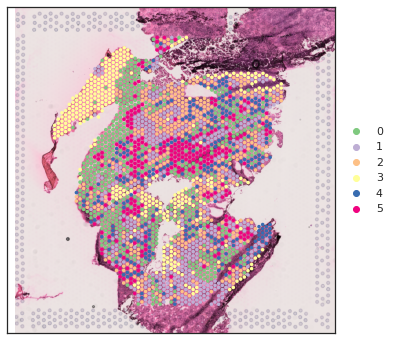

In [66]:
sample = samples[1]

sns.set_theme(style='white',palette='Accent')

adata = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

fig,ax = plt.subplots(figsize=(6,6))
#fig,ax = plt.subplots(figsize=(2,2))

sc.pl.spatial(adata,color='leiden',
                        crop_coord=sample_crop_coord[sample],
                        size=1.3, alpha_img=1,show=False,ax=ax,
 #                       legend_loc=None
                        )
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

#plt.savefig('./plots/met_samples/{}_clusters.png'.format(sample),dpi=1200)
plt.show()


### Plot a violin plot

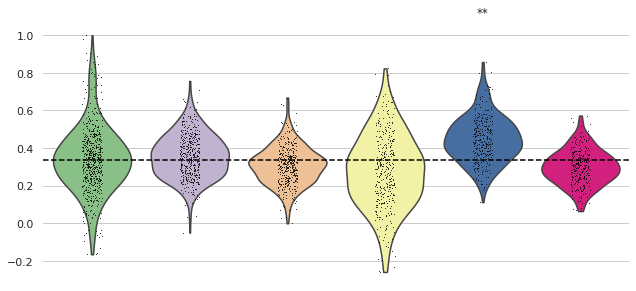

In [34]:
sample = samples[1]
signature = club_senescence
signature_name = 'Club_senescence'

dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

sc.tl.score_genes(dat,gene_list=signature,score_name=signature_name,use_raw=True)

dat.obs[signature_name] = dat.obs[signature_name]/dat.obs[signature_name].max() # Scale the scores

#cluster_order = dat.obs.groupby('leiden').mean()[signature_name].sort_values(ascending=False).index.tolist()

cluster_order = dat.obs['leiden'].cat.categories.tolist()
score_median = dat.obs[signature_name].median()

sns.set_theme(style='whitegrid',palette='Accent')

# Plot violins
fig, ax = plt.subplots(figsize=(len(cluster_order)*1.5,4.2))

ax.axhline(y=score_median,color='black',linestyle='--')

sc.pl.violin(dat,keys=signature_name,groupby='leiden',
             #inner='box',
             jitter=True,
             ax=ax,show=False
             #order = cluster_order 
             )

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

for cl in cluster_order:
    scores_cl = dat.obs[dat.obs['leiden']==cl][signature_name]
    scores_other = dat.obs[~(dat.obs['leiden']==cl)][signature_name]

    # Calculate t-test p-value
    stat, pval = ttest_ind(scores_cl,scores_other)

    cl_scores_desc = scores_cl.describe(percentiles=np.arange(0.1,1,0.1))

    if cl_scores_desc['10%'] >= score_median:
        ax.text(x=cl,y=1.1,s='***',ha='center')
    
    elif cl_scores_desc['20%'] >= score_median:
        ax.text(x=cl,y=1.1,s='**',ha='center')

    elif cl_scores_desc['30%'] >= score_median:
        ax.text(x=cl,y=1.1,s='*',ha='center')



ax.set_frame_on(False)
plt.tight_layout()
plt.savefig('./plots/met_samples/{}_cluster_violins_{}.pdf'.format(sample,signature_name))
    
plt.show()


### Plot gene set scores on a spatial section

In [ ]:

fig, ax = plt.subplots(figsize=(2,2))
sc.pl.spatial(dat,color=signature_name,title=signature_name,
                        crop_coord=sample_crop_coord[sample],
                        size=1.3, alpha_img=1, legend_loc=None,
                        show=False,ax=ax,
                        vmin=0,
                        vmax=dat.obs[signature_name].quantile(0.9),
                        colorbar_loc=None,
                        cmap='viridis'
                        )

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

plt.savefig('./plots/met_samples/{}_{}_score_spatial.png'.format(sample,signature_name),dpi=1200)
plt.show()

## Create an enrichment dotplot

In [373]:
signatures_to_test = {
    'PMN-MDSC': gene_set_df['CD300LD downstream'].dropna().tolist(),
    'EpiSen':gene_set_df['MP19 Epithelial Senescence'].dropna().tolist(),
    'Club': check_top_markers('Club epithelium')['gene'].tolist(),
    'Club_senescence':club_senescence,
    'High_NLR_associated': gene_set_df['NLR associated'].dropna().tolist()
}

In [37]:
for k in signatures_to_test:
    print(k)
    for sample in samples:

        print(sample)
        adata = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))
        check_cluster_enrichment(adata,signatures_to_test[k],return_pvals=False)
        print('\n')
    print('*************************\n')

PMN-MDSC
MET_A3
cluster 0 enrichment p-value: 1.000
cluster 1 enrichment p-value: 0.760


MET_GP12
cluster 0 enrichment p-value: 7.67e-06 !!
Overlap: XAF1 S100A8 S100A9 LCN2 ANXA1 PYGL EMILIN1 C3 C5AR1 F13A1 RAB31 IFITM3 ARHGDIB LGALS1 GSN
cluster 1 enrichment p-value: 0.605
cluster 2 enrichment p-value: 1.000
cluster 3 enrichment p-value: 5.24e-03 !!
Overlap: CHI3L1 SLPI
cluster 4 enrichment p-value: 3.60e-03 !!
Overlap: IFIT1 LCN2 CEACAM1
cluster 5 enrichment p-value: 1.000


MET_A14
cluster 0 enrichment p-value: 7.58e-03 !!
Overlap: CHI3L1 C3 HSD11B1 HP SCP2 IFITM3 NAMPT
cluster 1 enrichment p-value: 1.000
cluster 2 enrichment p-value: 1.000


MET_A16
cluster 0 enrichment p-value: 1.000
cluster 1 enrichment p-value: 2.89e-02 !!
Overlap: ANXA1 EMILIN1 IDH1 MCFD2 ALAS1 CD9 ZMPSTE24 ARHGDIB
cluster 2 enrichment p-value: 0.644


*************************

EpiSen
MET_A3
cluster 0 enrichment p-value: 1.000
cluster 1 enrichment p-value: 0.344


MET_GP12
cluster 0 enrichment p-value: 1.04e-

In [378]:
# Calculate gene set enrichmnents scores for a set list of signatures and
# Peform multiple testing correction

enrichment_res_df = pd.DataFrame(index=signatures_to_test.keys())
for sample in [samples[2],samples[1]]:

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    enrichment_pvalues_dict = {}
    for k in signatures_to_test:
        pvals = check_cluster_enrichment(dat,signatures_to_test[k],return_pvals=True)
        enrichment_pvalues_dict[k] = pvals

    res_df = pd.DataFrame(enrichment_pvalues_dict,
            index=[sample+ '_' + str(c) for c in list(np.arange(0,len(pvals))+1)]).T
    
    enrichment_res_df = pd.concat([enrichment_res_df,res_df],axis=1,ignore_index=False)

p_values = enrichment_res_df.values

# Perform FDR correction
reject, corrected_p_values = fdrcorrection(p_values.flatten())

# Reshape the corrected p-values to match the original DataFrame shape
corrected_p_values = corrected_p_values.reshape(enrichment_res_df.shape)

# Create a new DataFrame with the corrected p-values
df_corrected = enrichment_res_df.copy()
df_corrected[:] = corrected_p_values
df_corrected

,MET_A14_1,MET_A14_2,MET_A14_3,MET_GP12_1,MET_GP12_2,MET_GP12_3,MET_GP12_4,MET_GP12_5,MET_GP12_6
PMN-MDSC,3.158842e-02,1.000000,1.0,8.632470e-05,1.000000,1.0,0.026187,2.315569e-02,1.000000
EpiSen,9.265949e-01,1.000000,1.0,3.905768e-02,0.934887,1.0,0.172204,5.346318e-02,1.000000
Club,3.163928e-07,0.581701,1.0,3.418216e-07,0.000152,1.0,0.065502,1.261602e-13,0.820543
Club_senescence,1.000000e+00,1.000000,1.0,3.158842e-02,1.000000,1.0,0.096611,2.443428e-02,1.000000
High_NLR_associated,6.324404e-02,1.000000,1.0,2.547375e-03,1.000000,1.0,1.000000,1.000000e+00,1.000000


In [375]:
df_corrected_transformed = -np.log10(df_corrected)
df_corrected_transformed[df_corrected_transformed <= -np.log10(0.05)] = np.nan

first_cols = df_corrected_transformed.columns[:3].tolist()
last_cols = df_corrected_transformed.columns[-6:].tolist()

idx_list = df_corrected_transformed.index.tolist()

# Add padding to the dataframe
df_corrected_transformed['div1'] = np.nan
df_corrected_transformed['div2'] = np.nan
df_corrected_transformed['div3'] = np.nan

df_corrected_transformed = df_corrected_transformed[['div1'] + first_cols + ['div2'] + last_cols + ['div3']]

df_corrected_transformed

,div1,MET_A14_1,MET_A14_2,MET_A14_3,div2,MET_GP12_1,MET_GP12_2,MET_GP12_3,MET_GP12_4,MET_GP12_5,MET_GP12_6,div3
PMN-MDSC,NaN,1.500472,NaN,NaN,NaN,4.063865,NaN,NaN,1.581912,1.635342,NaN,NaN
EpiSen,NaN,NaN,NaN,NaN,NaN,1.408294,NaN,NaN,NaN,NaN,NaN,NaN
Club,NaN,6.499773,NaN,NaN,NaN,6.466201,3.816801,NaN,NaN,12.899078,NaN,NaN
Club_senescence,NaN,NaN,NaN,NaN,NaN,1.500472,NaN,NaN,NaN,1.612001,NaN,NaN
High_NLR_associated,NaN,NaN,NaN,NaN,NaN,2.593907,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
plot_df = df_corrected_transformed.reset_index(drop=True).melt(ignore_index=False).reset_index()
plot_df['variable'] = pd.Categorical(plot_df['variable'],categories=df_corrected_transformed.columns)



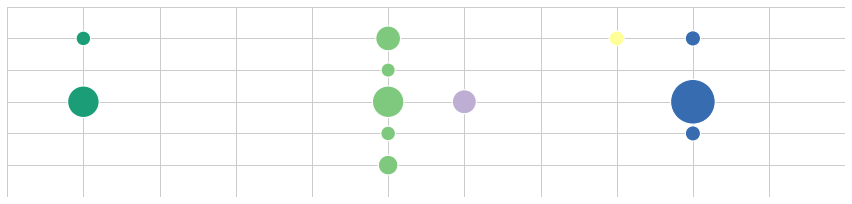

In [63]:
# Dark2 with first 6 colors + first 3 repeated to get the column match
color_pal = ['#000000','#1b9e77', '#d95f02', '#7570b3','#000000','#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f','#000000']
sns.set_theme(style='whitegrid',palette=sns.color_palette(color_pal))

fig, ax = plt.subplots(figsize=(12,3))
sns.scatterplot(plot_df,
                x='variable',
                y='index',
                size='value',
                hue='variable',
                sizes=(200,2000),
                legend=False
                
                )

ax.set_xticks(df_corrected_transformed.columns)
ax.set_ylim(5,-1)
ax.set_xticklabels('',rotation=20)
ax.set_yticklabels('',rotation=20)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

ax.set_frame_on(False)
plt.tight_layout()
plt.savefig('./plots/met_samples/enrichment_dotplot_samples_GP12_A14.pdf')
plt.show()

## Supplementary plots

In [18]:
region_signatures_to_test = {
    'Tumor': check_top_markers('Tumor')['gene'].tolist(),
    'Luminal': check_top_markers('Luminal epithelium')['gene'].tolist(),
    'Basal': check_top_markers('Basal epithelium')['gene'].tolist(),
    'Club': check_top_markers('Club epithelium')['gene'].tolist(),
    'Immune': check_top_markers('Immune')['gene'].tolist(),
    'Endothelium': check_top_markers('Endothelium')['gene'].tolist(),
    'Fibroblast': check_top_markers('Fibroblast')['gene'].tolist(),
    'Muscle': check_top_markers('Muscle')['gene'].tolist(),
}

sample_ids = {
    samples[2]:'A',
    samples[1]:'B',
    samples[0]:'C',
    samples[3]:'D',
}

samples_palettes = {
    samples[2]:'Dark2',
    samples[1]:'Accent',
    samples[0]:'tab10',
    samples[3]:'Paired',

}

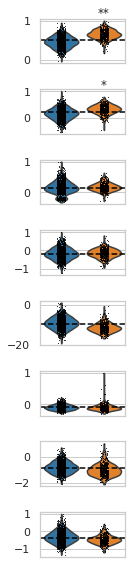

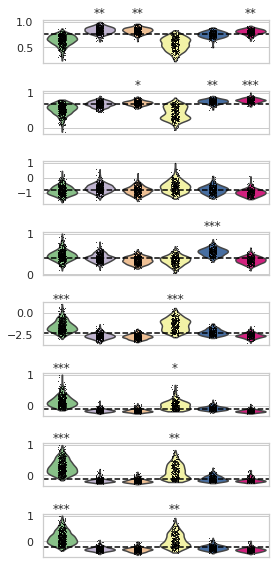

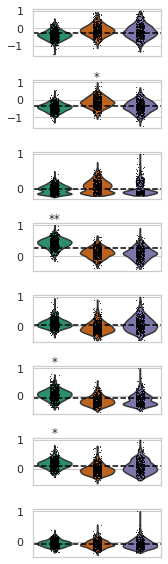

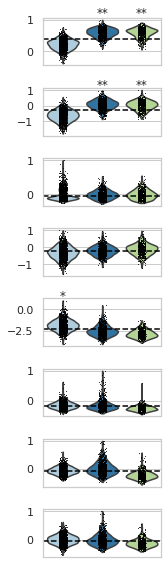

In [140]:
for sample in samples:
#sample = samples[1]

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    cluster_order = dat.obs['leiden'].cat.categories.tolist()

    fig, axes = plt.subplots(8,1,figsize=(1 + 0.5*len(cluster_order),8))

    for idx,k in enumerate(region_signatures_to_test):
        
        ax = axes[idx]
        pal = samples_palettes[sample]
        sample_id = sample_ids[sample]

        sns.set_theme(style='whitegrid',palette=pal)


        sc.tl.score_genes(dat,gene_list=region_signatures_to_test[k],score_name=k,use_raw=True)
        dat.obs[k] = dat.obs[k]/dat.obs[k].max() # Scale the scores

        score_median = dat.obs[k].median()


        ax.axhline(y=score_median,color='black',linestyle='--')

        sc.pl.violin(dat,keys=k,groupby='leiden',
                    #inner='box',
                    jitter=True,
                    ax=ax,show=False
                    )

        ax.set_xticklabels('')
        ax.set_xlabel('')
        ax.set_ylabel(None)
        ax.set_title('')

        for cl in cluster_order:
            scores_cl = dat.obs[dat.obs['leiden']==cl][k]
            scores_other = dat.obs[~(dat.obs['leiden']==cl)][k]

            # Calculate t-test p-value
            stat, pval = ttest_ind(scores_cl,scores_other)

            cl_scores_desc = scores_cl.describe(percentiles=np.arange(0.1,1,0.1))

            if cl_scores_desc['10%'] >= score_median:
                ax.text(x=cl,y=1.1,s='***',ha='center')
            
            elif cl_scores_desc['20%'] >= score_median:
                ax.text(x=cl,y=1.1,s='**',ha='center')

            elif cl_scores_desc['30%'] >= score_median:
                ax.text(x=cl,y=1.1,s='*',ha='center')



        #ax.set_frame_on(False)
    plt.tight_layout()
    plt.savefig('./plots/met_samples/{}_cluster_violins_all_regions_violin_plot.pdf'.format(sample))
        
    plt.show()


### Enrichment dotplot

In [84]:
enrichment_res_df = pd.DataFrame(index=region_signatures_to_test.keys())
for sample in list(sample_ids.keys()):

    dat = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    enrichment_pvalues_dict = {}
    for k in region_signatures_to_test:
        pvals = check_cluster_enrichment(dat,region_signatures_to_test[k],return_pvals=True)
        enrichment_pvalues_dict[k] = pvals

    res_df = pd.DataFrame(enrichment_pvalues_dict,
            index=[sample+ '_' + str(c) for c in list(np.arange(0,len(pvals))+1)]).T
    
    enrichment_res_df = pd.concat([enrichment_res_df,res_df],axis=1,ignore_index=False)


# Assuming your DataFrame is named 'df' and contains p-values
p_values = enrichment_res_df.values

# Perform FDR correction
reject, corrected_p_values = fdrcorrection(p_values.flatten())

# Reshape the corrected p-values to match the original DataFrame shape
corrected_p_values = corrected_p_values.reshape(enrichment_res_df.shape)

# Create a new DataFrame with the corrected p-values
df_corrected = enrichment_res_df.copy()
df_corrected[:] = corrected_p_values


In [87]:
df_corrected

,MET_A14_1,MET_A14_2,MET_A14_3,MET_GP12_1,MET_GP12_2,MET_GP12_3,MET_GP12_4,MET_GP12_5,MET_GP12_6,MET_A3_1,MET_A3_2,MET_A16_1,MET_A16_2,MET_A16_3
Tumor,1.000000e+00,0.135264,1.0,1.000000e+00,3.131384e-07,0.135264,1.000000e+00,9.620972e-01,1.723617e-03,1.0,0.300512,1.0,1.000000e+00,0.000024
Luminal,1.000000e+00,0.022665,1.0,1.000000e+00,2.404270e-05,0.216358,1.000000e+00,4.354133e-03,4.873948e-12,1.0,0.026911,1.0,2.361828e-03,0.025407
Basal,1.000000e+00,0.962097,1.0,9.620972e-01,6.632583e-02,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,1.000000e+00,1.000000
Club,1.574933e-07,0.685795,1.0,2.320243e-07,1.116159e-04,1.000000,9.057046e-02,4.485696e-14,9.620972e-01,1.0,1.000000,1.0,9.620972e-01,0.216916
Immune,1.000000e+00,1.000000,1.0,8.356321e-38,1.000000e+00,1.000000,1.000000e+00,5.858757e-01,1.000000e+00,1.0,1.000000,1.0,2.169157e-01,1.000000
Endothelium,5.945328e-01,0.962097,1.0,1.900703e-93,1.000000e+00,1.000000,6.626033e-02,9.810781e-01,1.000000e+00,1.0,0.585876,1.0,3.283277e-14,1.000000
Fibroblast,4.126751e-02,1.000000,1.0,8.090492e-186,1.000000e+00,1.000000,4.973712e-13,1.000000e+00,9.620972e-01,1.0,1.000000,1.0,5.362923e-33,1.000000
Muscle,1.000000e+00,1.000000,1.0,8.611158e-44,9.620972e-01,1.000000,1.243600e-05,1.000000e+00,4.582725e-01,1.0,1.000000,1.0,2.441277e-05,1.000000


In [160]:
df_corrected_transformed = -np.log10(df_corrected)
df_corrected_transformed[df_corrected_transformed <= -np.log10(0.05)] = np.nan

cols1 = df_corrected_transformed.columns[:3].tolist()
cols2 = df_corrected_transformed.columns[3:9].tolist()
cols3 = df_corrected_transformed.columns[9:11].tolist()
cols4 = df_corrected_transformed.columns[11:14].tolist()

idx_list = df_corrected_transformed.index.tolist()

# Add padding to the dataframe
df_corrected_transformed['div1'] = np.nan
df_corrected_transformed['div2'] = np.nan
df_corrected_transformed['div3'] = np.nan

df_corrected_transformed = df_corrected_transformed[cols1 + ['div1'] + cols2 + ['div2'] + cols3 + ['div3'] + cols4]

# Clip the scale to 10^-100
#plot_df = df_corrected_transformed.clip(upper=100)
plot_df = df_corrected_transformed.reset_index(drop=True).melt(ignore_index=False).reset_index()

plot_df['variable'] = pd.Categorical(plot_df['variable'],categories=df_corrected_transformed.columns)

df_corrected_transformed

,MET_A14_1,MET_A14_2,MET_A14_3,div1,MET_GP12_1,MET_GP12_2,MET_GP12_3,MET_GP12_4,MET_GP12_5,MET_GP12_6,div2,MET_A3_1,MET_A3_2,div3,MET_A16_1,MET_A16_2,MET_A16_3
Tumor,NaN,NaN,NaN,NaN,NaN,6.504264,NaN,NaN,NaN,2.763559,NaN,NaN,NaN,NaN,NaN,NaN,4.619017
Luminal,NaN,1.64464,NaN,NaN,NaN,4.619017,NaN,NaN,2.361098,11.312119,NaN,NaN,1.570067,NaN,NaN,2.626752,1.595051
Basal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Club,6.802738,NaN,NaN,NaN,6.634466,3.952274,NaN,NaN,13.348170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Immune,NaN,NaN,NaN,NaN,37.077985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Endothelium,NaN,NaN,NaN,NaN,92.721086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.483692,NaN
Fibroblast,1.384392,NaN,NaN,NaN,185.092025,NaN,NaN,12.303319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.270598,NaN
Muscle,NaN,NaN,NaN,NaN,43.064938,NaN,NaN,4.905319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.612383,NaN


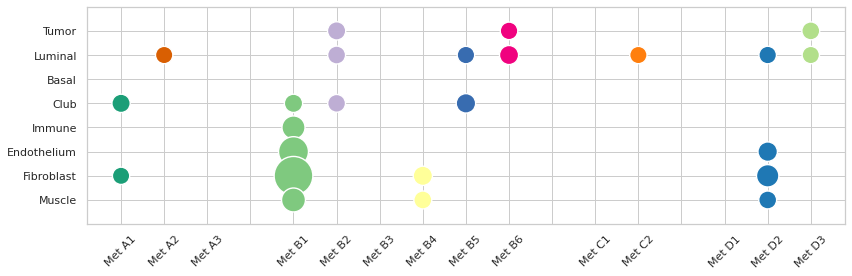

In [161]:
# Dark2 with first 6 colors + first 3 repeated to get the column match
color_pal = (
    sns.color_palette(list(samples_palettes.values())[0],3).as_hex() + ['#000000'] +
    sns.color_palette(list(samples_palettes.values())[1],6).as_hex() + ['#000000'] + 
    sns.color_palette(list(samples_palettes.values())[2],2).as_hex() + ['#000000'] + 
    sns.color_palette(list(samples_palettes.values())[3],3).as_hex()
)
             


sns.set_theme(style='whitegrid',palette=sns.color_palette(color_pal))

fig, ax = plt.subplots(figsize=(12,4))
sns.scatterplot(plot_df,
                x='variable',
                y='index',
                size='value',
                hue='variable',
                sizes=(300,1500),
                legend=False
                
                )


x_ticklabels = (
    ['Met {}{}'.format('A',str(cl)) for cl in np.arange(3) + 1] + [''] + 
    ['Met {}{}'.format('B',str(cl)) for cl in np.arange(6) + 1] + [''] + 
    ['Met {}{}'.format('C',str(cl)) for cl in np.arange(2) + 1] + [''] + 
    ['Met {}{}'.format('D',str(cl)) for cl in np.arange(3) + 1] 
 
)

y_ticklabels = (
    [''] +
    [r.split(' ')[0] for r in regions] +
    ['']
)

ax.set_xticklabels(x_ticklabels,rotation=45)

ax.set_ylim(8,-1)
ax.set_yticklabels(y_ticklabels)
#ax.set_yticklabels('',rotation=20)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

#ax.set_frame_on(False)
plt.tight_layout()
plt.savefig('./plots/met_samples/enrichment_dotplot_region_markers_all_samples.pdf')
plt.show()

### Clusters overlaid on the spatial section

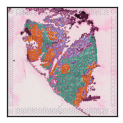

In [168]:
for sample in samples:

    sns.set_theme(style='white',palette=samples_palettes[sample])

    adata = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    #fig,ax = plt.subplots(figsize=(6,6))
    fig,ax = plt.subplots(figsize=(2,2))

    sc.pl.spatial(adata,color='leiden',
                            crop_coord=sample_crop_coord[sample],
                            size=1.3, alpha_img=1,show=False,ax=ax,
                            legend_loc=None
                            )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

    plt.savefig('./plots/met_samples/{}_clusters.png'.format(sample),dpi=1200)
    plt.show()


### Generate a supplementary table with DEG results

In [365]:
deg_results_dict = {}

for sample in sample_ids.keys():
    adata = sc.read_h5ad('./data/visium_with_regions_and_degs/{}_with_regions_and_degs.h5ad'.format(sample))

    deg_res = sc.get.rank_genes_groups_df(adata,group=None)

    # Delete mitochondrial and ribosomal genes
    deg_res = deg_res[~((deg_res['names'].str.startswith('MT-')) | (deg_res['names'].str.startswith('RPS')) | (deg_res['names'].str.startswith('RPS')))].reset_index(drop=True)

    # Fix the cluster identities
    deg_res['group'] = pd.Categorical(pd.Series(np.repeat('Met {}'.format(sample_ids[sample]),len(deg_res))) +  (deg_res['group'].astype(int) + 1).astype(str))

    deg_results_dict['Met '+ sample_ids[sample]] = deg_res


In [366]:
# Write the degs into a excel
with pd.ExcelWriter('./supplementary_tables/metastasis_samples_degs.xlsx') as writer:
    for sheet_name, df in deg_results_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=True)

### Check specific enrichments

In [21]:
sample = samples[2]
#sample = 'PC_4980'
n_top = 10

# Download the raw counts to denote baseline expression
adata = sc.read_10x_h5('./results/{}/outs/filtered_feature_bc_matrix.h5'.format(sample))
adata.var_names_make_unique()


for region in region_signatures_to_test.keys():
    # Get the list of signatures 
    genes = np.array(region_signatures_to_test[region][:n_top])

    # What percentage of spots contain at least one single transcript of the gene
    pct_expressing_arr = ((adata[:,genes].X.todense() != 0).sum(axis=0)/adata.shape[0] * 100).round(1)[0]

    # Sort the indices into a descending order
    idx_order = np.argsort(pct_expressing_arr)[::-1]
    pct_expressing_arr = pct_expressing_arr[idx_order]
    genes = genes[idx_order]

    print('Pct of spots expressing {} region genes in Met {} ({}):'.format(region,sample_ids[sample],sample))
    #print('Pct of spots expressing {} region genes in Met {}:\n'.format(region,sample))

    #for idx,entry in enumerate(pct_expressing_arr):
    #    print('{}: {}% expressing'.format(genes[idx],entry))

    pct_spots_expressing_any = ((adata[:,genes].X.todense() != 0).sum(axis=1) != 0).sum()/len(adata)
    print('Spots expressing any of the top {} genes: {:.1%}\n'.format(n_top,pct_spots_expressing_any))

Pct of spots expressing Tumor region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 80.9%

Pct of spots expressing Luminal region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 99.8%

Pct of spots expressing Basal region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 68.8%

Pct of spots expressing Club region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 69.7%

Pct of spots expressing Immune region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 37.5%

Pct of spots expressing Endothelium region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 72.2%

Pct of spots expressing Fibroblast region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 96.7%

Pct of spots expressing Muscle region genes in Met PC_4980:

Spots expressing any of the top 10 genes: 99.6%



In [339]:
sample = samples[3]
region = 'Club'
#sample = 'PC_4980'
n_top = 50

# Download the raw counts to denote baseline expression
adata = sc.read_10x_h5('./results/{}/outs/filtered_feature_bc_matrix.h5'.format(sample))
adata.var_names_make_unique()



# Get the list of signatures 
genes = np.array(region_signatures_to_test[region][:n_top])

# What percentage of spots contain at least one single transcript of the gene
pct_expressing_arr = ((adata[:,genes].X.todense() != 0).sum(axis=0)/adata.shape[0] * 100).round(1)[0]

# Sort the indices into a descending order
idx_order = np.argsort(pct_expressing_arr)[::-1]
pct_expressing_arr = pct_expressing_arr[idx_order]
genes = genes[idx_order]

print('Pct of spots expressing {} region genes in Met {} ({}):\n'.format(region,sample_ids[sample],sample))
#print('Pct of spots expressing {} region genes in Met {}:\n'.format(region,sample))

for idx,entry in enumerate(pct_expressing_arr):
    print('{}: {}% expressing'.format(genes[idx],entry))


Pct of spots expressing Club region genes in Met D (MET_A16):

VMP1: 32.8% expressing
ANXA2: 24.4% expressing
ST6GAL1: 22.9% expressing
CLDN4: 16.9% expressing
ELF3: 16.2% expressing
NPC2: 11.4% expressing
SOD2: 8.8% expressing
ATF3: 6.5% expressing
TNFRSF21: 6.4% expressing
CXCL16: 6.0% expressing
SCUBE2: 4.3% expressing
KRT19: 3.5% expressing
SLPI: 3.4% expressing
NCOA7: 3.1% expressing
LXN: 1.7% expressing
RHOV: 1.6% expressing
ATP1B1: 1.6% expressing
KLF5: 1.5% expressing
MPZL2: 1.4% expressing
PRSS22: 1.4% expressing
GPRC5A: 1.1% expressing
MUC1: 1.0% expressing
CDH3: 0.9% expressing
ASS1: 0.8% expressing
TNFSF15: 0.5% expressing
CFB: 0.5% expressing
WFDC2: 0.5% expressing
TNFAIP2: 0.5% expressing
CP: 0.3% expressing
CEACAM1: 0.3% expressing
DUSP4: 0.3% expressing
CLDN1: 0.2% expressing
MMP7: 0.2% expressing
S100P: 0.2% expressing
LCN2: 0.1% expressing
OLFM4: 0.1% expressing
RARRES1: 0.1% expressing
KRT17: 0.1% expressing
ITGB6: 0.0% expressing
GABRP: 0.0% expressing
MET: 0.0% exp